# Future Perspectives

Possible evolutions of this project in a future, more in-depth analysis of the problem.

### Rebuild the datasets and models used in the original analysis

In [1]:
# General
import string
import numpy as np
import pandas as pd
import warnings

# Gensim
import gensim
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, KeyedVectors
from gensim.models.wrappers import LdaMallet
from gensim.test.utils import datapath

# Lemmatization
import spacy

# Silhouette index and shuffle method
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.utils import shuffle

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [5]:
def preprocess_text(text, nlp, stop_words = [], pos = ['PROPN', 'NOUN', 'VERB', 'ADJ']):
    """
    Performs preprocessing on a text through spaCy, langauge based on nlp parameter.
    Filter default stopword plus those in the list stop_words,
    accepts only word with POS tag in the pos list,
    filters out non-alpha words, performs lemmatization.
    Returns a list of lemmatized, filtered tokens for the text.
    """
    doc = nlp(text.lower())
    tokens = []
    for token in doc:
        if token.lemma_ not in stop_words and token.pos_ in pos and not token.is_stop and token.is_alpha:
            tokens.append(token.lemma_)
    return tokens

def create_lda_model(dictionary, corpus, num_topics, num_words = 20, passes = 20):
    """
    Creates an LDA model using gensim.
    Dictionary and corpus should be obtained with corpora.
    Number of topics and number of passes should be tweaked depending on context.
    """
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=42)
    return lda_model

def get_lda_keywords(model, num_words = 20):
    """
    Extract the firt num_words keywords from all topics of a gensim LDA model.
    """
    num_topics = len(model.print_topics())
    return [[tup2[0] for tup2 in tup[1]]for tup in model.show_topics(formatted=False, num_topics=num_topics, num_words=num_words)]
    
def create_paper_points_data(lda_model, corpus, num_topics):
    """
    Creates a dataframe with topic scores for each text in corpus using a gensim LDA model.
    """
    x = [[] for i in range(num_topics)]
    for text in corpus:
        l_tup = lda_model[text]
        for val in range(num_topics):
            added = False
            for tup in l_tup:
                if tup[0] == val:
                    x[val].append(tup[1])
                    added = True
            if added == False:
                x[val].append(0)
    df = pd.DataFrame(x)
    df = df.transpose()
    df.columns = ['Topic' + str(n) for n in range(num_topics)]
    return df

def compute_silhouette(lda_model, corpus, num_topics):
    """
    Computes silhouette index for an LDA model based on topics it classified.
    """
    points = create_paper_points_data(lda_model, corpus, num_topics).values
    lda_labels = points.argmax(axis=1) 
    return silhouette_score(points, lda_labels)
    
def compute_perplexity(lda_model, corpus):
    """
    Computes perplexity score for an LDA model.
    """
    perplexity = lda_model.log_perplexity(corpus)
    return perplexity

def compute_coherence(lda_model, texts, corpus, dictionary, coherence = "c_v"):
    """
    Computes coherence score for an LDA model.
    """
    score = CoherenceModel(model=lda_model, texts=texts, corpus=corpus, dictionary=dictionary, coherence=coherence).get_coherence()
    return score

def assess_model_goodness(lda_model, texts, corpus, dictionary, num_topics):
    """
    Assess the goodness of an LDA model using coherence and silhouette scores.
    """
    points = create_paper_points_data(lda_model, corpus, num_topics).values
    lda_labels = points.argmax(axis=1)
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(points) + (n + 1) * 10])
    silhouette_avg = silhouette_score(points, lda_labels)
    print("For {} topic the average silhouette score is : {}\n".format(num_topics, silhouette_avg))
    #print("Perplexity: {}\n".format(compute_perplexity(lda_model, corpus)))
    print("Coherence: {}\n".format(compute_coherence(lda_model, texts, corpus, dictionary, "c_v")))
    sample_silhouette_values = silhouette_samples(points, lda_labels)
    y_lower = 10
    for i in range(num_topics):
        ith_topic_silhouette_values = sample_silhouette_values[lda_labels == i]
        ith_topic_silhouette_values.sort()
        size_topic_i = ith_topic_silhouette_values.shape[0]
        y_upper = y_lower + size_topic_i
        color = cm.nipy_spectral(float(i) / num_topics)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_topic_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower + 0.5 * size_topic_i, str(i))
        y_lower = y_upper + 10
    ax1.set_title("Silhouette plot for " + str(num_topics) + " topics.")
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Topic number")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

In [9]:
# Ignore warnings in libraries
warnings.filterwarnings("ignore")

# Import Italo Svevo corpus dataset
data = pd.read_csv('datasets/carteggio.svevo3.csv', sep=';', parse_dates=['date'])

# Spacy languages
# Load modules using sudo python -m spacy download <lang>
nlp_it = spacy.load("it", disable=['parser', 'ner'])

# Italian letters dataframe, corpus and dictionary
data_it = data[data.mainLanguage == "ITA"]
texts_it = [preprocess_text(text, nlp_it, pos = ['PROPN', 'NOUN']) for text in data_it["text"]]
d_it = corpora.Dictionary(texts_it)
d_it.filter_extremes(no_below=5, no_above=0.5)
c_it = [d_it.doc2bow(text) for text in texts_it]

n_topics = 10
models_it = []
for n in range(2, n_topics):
    model_it = create_lda_model(d_it, c_it, n, passes = 20)
    models_it.append(model_it)

In [11]:
X = create_paper_points_data(models_it[3], c_it, 3)
df = data_it
df["lbl"] = pd.Categorical(X.values.argmax(axis=1))
df_n = [df[df["lbl"] == n] for n in range(3)]

## Two-steps LDA

It would be interesting to try a two-steps LDA approach proposed in [Medvet & al.(2014)](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxtYWNoaW5lbGVhcm5pbmd0c3xneDo3YTQ5OTdjMWRkZjBiMmZm) with our filtered dictionary, since the same approach with the regular one didn't hold satisfactory results.

In [13]:
data_family = df_n[0]
texts_t0 = [preprocess_text(text, nlp_it, pos = ['PROPN', 'NOUN']) for text in data_family["text"]]
d_t0 = corpora.Dictionary(texts_t0)
c_t0 = [d_t0.doc2bow(text) for text in texts_t0]

For 2 topic the average silhouette score is : 0.7778832063480634

Coherence: 0.5216320151555931



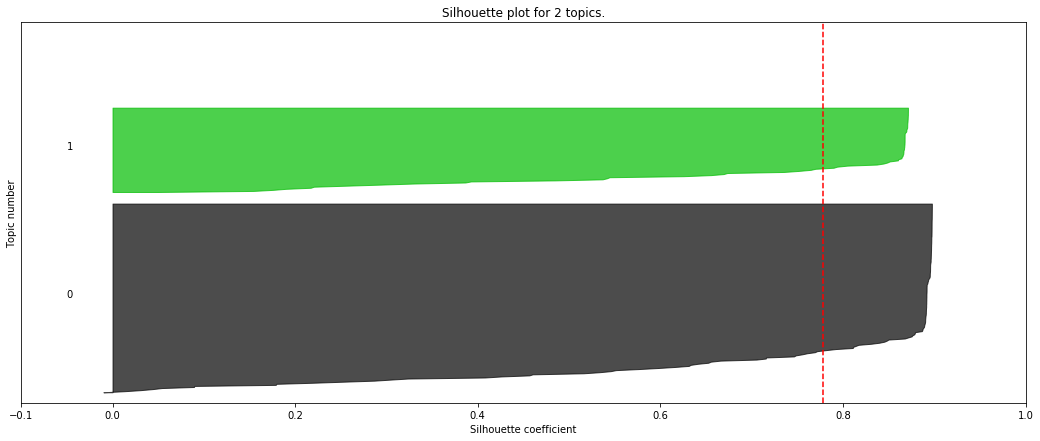

In [15]:
model_t0 = create_lda_model(d_t0, c_t0, 2, passes = 100)
assess_model_goodness(model_t0, texts_t0, c_t0, d_t0, 2)

## Similarity inside topics using Word2Vec italian embeddings

We used the embedding produced by the Italian NLP Lab, available [here](http://www.italianlp.it/resources/italian-word-embeddings/).
To use this, simply download the itwac128.txt file and put it inside the datasets folder.

First step is filtering out words containing alpha characters, since they break the gensim W2V algorithm.

In [283]:
from tqdm import tqdm

# Repeated from above
data_it = data[data.mainLanguage == "ITA"]
texts_it = [preprocess_text(text, nlp_it, stop_words=stop_words, pos = ['PROPN', 'NOUN']) for text in data_it["text"]]
d_it = corpora.Dictionary(texts_it)
d_it.filter_extremes(no_below=5, no_above=0.5)
c_it = [d_it.doc2bow(text) for text in texts_it]

file_r = open("datasets/itwac128.txt", "r")
file_w = open("datasets/we_it.txt", "w")
for line in tqdm(file_r):
    line_vec = line.split("\t")
    if(str(line_vec[0]).isalpha()):
        file_w.write(" ".join(line_vec))
print(sum(1 for _ in file_w))

1247492it [00:21, 56988.41it/s]


We try out the italian semantic vector we just created

In [ ]:
vectors = KeyedVectors.load_word2vec_format('we_it.txt', binary = False)
vectors.most_similar(positive=['gatto', 'topo'], topn=10)

Finally, we show the vocabulary of our letter corpus in 2D, matching words to their W2V vectors projected on principal components.
We highlight in different colors the words that belong to the different topics we found.

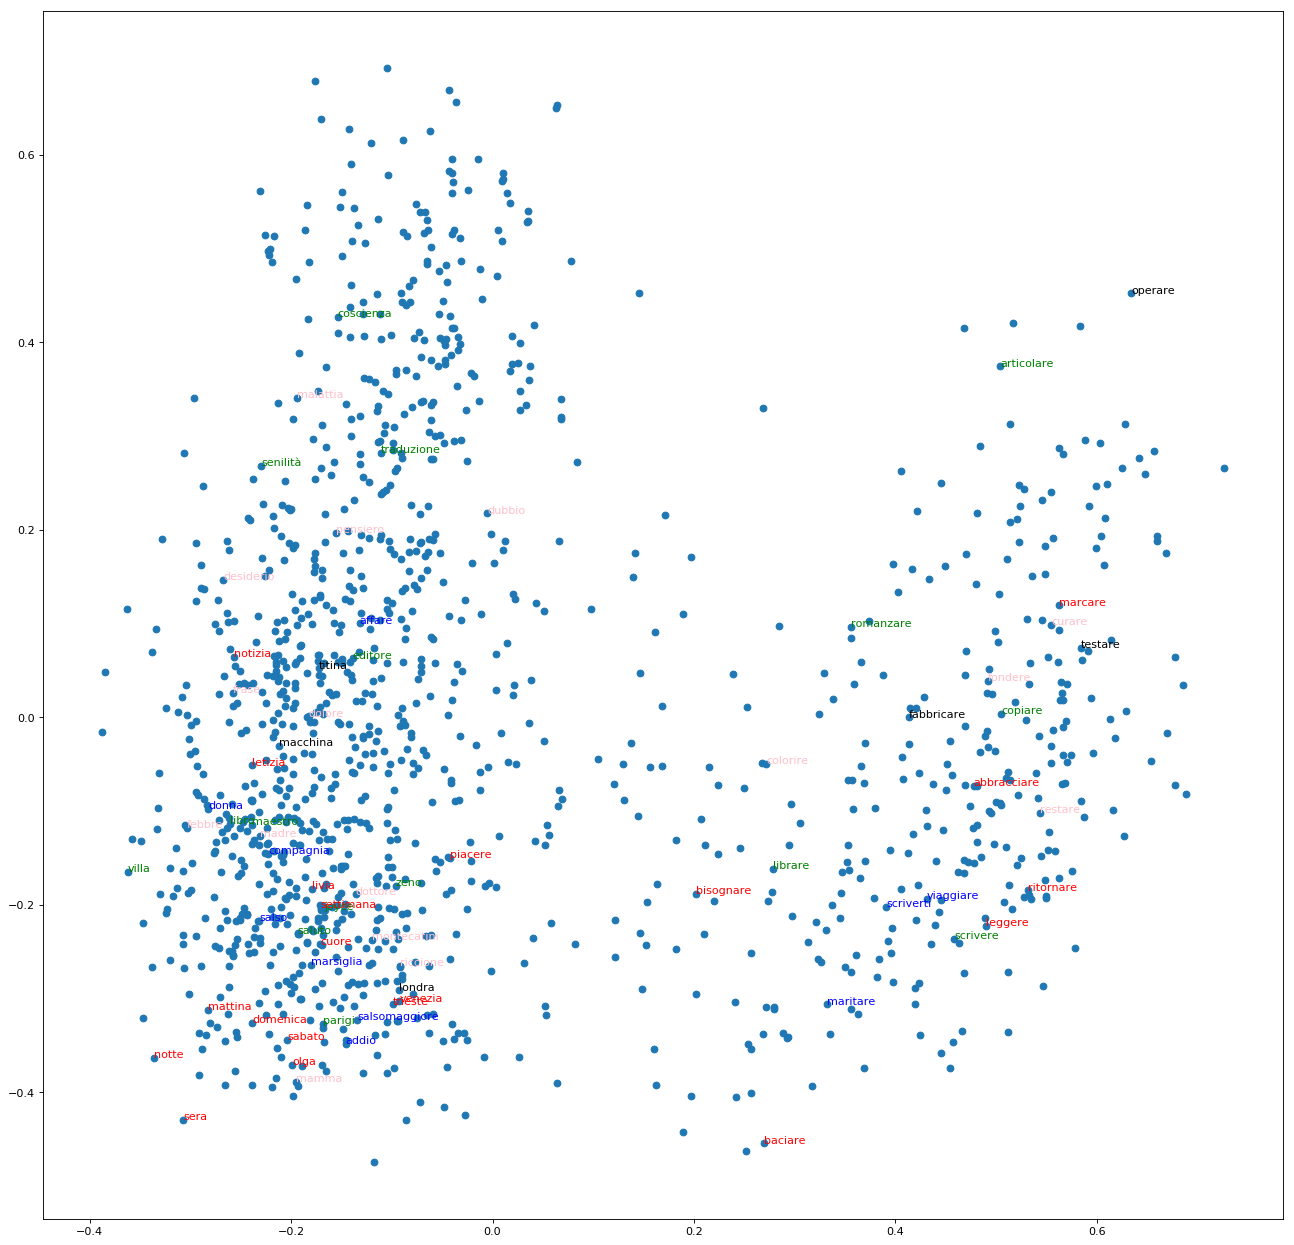

In [485]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
from matplotlib.pyplot import figure

# Create an LDA model with 5 topics.
lda_model = create_lda_model(d_it, c_it, 5, passes = 200)

# Extract sentences from our dataframe.
sentences = [[d_it[id] for id, freq in cp] for cp in c_it]

# Build Word2Vec model from corpus sentences.
w2v_model = Word2Vec(sentences, min_count=1)

# Filter corpus vocabulary based on W2V lexicon.
f_vocab = {k:v for k,v in model.wv.vocab.items() if k in vectors.wv.vocab}

# Transform W2V vectors on 2D vectors based on principal components.
X = vectors[f_vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# Show vectors in space
figure(num=None, figsize=(20, 20), dpi=80, facecolor='w', edgecolor='k')
pyplot.scatter(result[:, 0], result[:, 1])
words = list(f_vocab)
keywords = get_lda_keywords(lda_model)
for i, word in enumerate(words):
    if word in keywords[0]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = "red") # family
    elif word in keywords[1]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = "green") # literature
    elif word in keywords[2]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = "black") # work
    elif word in keywords[3]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = "blue") # travel
    elif word in keywords[4]:
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]), color = "pink") # health
    #else:
    #    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()